<a href="https://colab.research.google.com/github/adithyaac/Captcha-breaker/blob/main/Task%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as my_classification_report
import matplotlib.pyplot as plt

IMAGE_SIZE = (150, 50)
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
NUM_CLASSES = 100

In [16]:
class CAPTCHADataset(Dataset):

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [17]:
class CAPTCHAClassifier(nn.Module):

    def __init__(self, num_classes):

        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
        )

        self.flatten_size = 128 * (IMAGE_SIZE[0] // 8) * (IMAGE_SIZE[1] // 8)

        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.flatten_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, self.flatten_size)
        x = self.fc_layers(x)
        return x

In [18]:
def load_dataset(easy_dir, hard_dir, num_words=100):

    image_paths = []
    labels = []
    word_to_idx = {}
    idx_to_word = {}
    current_idx = 0

    for directory in [easy_dir, hard_dir]:
        for filename in os.listdir(directory):

            word = filename.split('_')[1].split('.')[0].lower()

            if word not in word_to_idx and len(word_to_idx) < num_words:
                word_to_idx[word] = current_idx
                idx_to_word[current_idx] = word
                current_idx += 1

            if word in word_to_idx:
                image_paths.append(os.path.join(directory, filename))
                labels.append(word_to_idx[word])

    return image_paths, labels, word_to_idx, idx_to_word

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_acc = 0
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)
        if early_stopping_counter >= 5:
            print(f'I am triggering an early stopping after epoch {epoch+1}')
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [20]:
def evaluate_model(model, test_loader, criterion, device, idx_to_word):

    model.eval()
    test_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)

    pred_words = [idx_to_word[idx] for idx in all_predictions]
    true_words = [idx_to_word[idx] for idx in all_labels]

    report = my_classification_report(true_words, pred_words)
    return test_loss, report

In [24]:

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
transform_train = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [25]:
!git clone https://github.com/adithyaac/Captcha-breaker.git

DATASET_PATH = './Captcha-breaker/captcha_dataset'

EASY_DIR = f'{DATASET_PATH}/easy'
HARD_DIR = f'{DATASET_PATH}/hard'

image_paths, labels, word_to_idx, idx_to_word = load_dataset(
     EASY_DIR,
     HARD_DIR,
    num_words=NUM_CLASSES
)

fatal: destination path 'Captcha-breaker' already exists and is not an empty directory.


In [10]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=42
)

In [26]:
train_dataset = CAPTCHADataset(train_paths, train_labels, transform_train)
val_dataset = CAPTCHADataset(val_paths, val_labels, transform_val)
test_dataset = CAPTCHADataset(test_paths, test_labels, transform_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [27]:
model = CAPTCHAClassifier(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

Starting training...
Epoch [1/50]
Train Loss: 3.8980, Train Acc: 11.26%
Val Loss: 2.5615, Val Acc: 36.73%
------------------------------------------------------------
Epoch [2/50]
Train Loss: 2.5370, Train Acc: 40.18%
Val Loss: 1.8472, Val Acc: 55.72%
------------------------------------------------------------
Epoch [3/50]
Train Loss: 2.1292, Train Acc: 49.47%
Val Loss: 1.5675, Val Acc: 61.20%
------------------------------------------------------------
Epoch [4/50]
Train Loss: 1.8430, Train Acc: 55.10%
Val Loss: 1.2921, Val Acc: 66.28%
------------------------------------------------------------
Epoch [5/50]
Train Loss: 1.6333, Train Acc: 59.32%
Val Loss: 1.1880, Val Acc: 69.70%
------------------------------------------------------------
Epoch [6/50]
Train Loss: 1.4898, Train Acc: 62.55%
Val Loss: 0.9306, Val Acc: 75.05%
------------------------------------------------------------
Epoch [7/50]
Train Loss: 1.3812, Train Acc: 64.75%
Val Loss: 0.8108, Val Acc: 78.70%
------------------

<ipython-input-28-b9d64fed0927>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Test Results:
Test Loss: 0.2124

Classification Report:
              precision    recall  f1-score   support

       about       0.97      0.97      0.97        78
       above       0.90      0.99      0.94        77
      accept       0.97      0.97      0.97        76
      access       0.91      0.98      0.94       107
     account       0.90      0.96      0.93        75
      across       0.94      0.96      0.95        93
      action       0.96      0.93      0.94        81
      actual       0.96      0.97      0.97        75
     address       0.99      0.94      0.96        95
      advice       0.99      0.92      0.95        90
      affect       0.97      0.93      0.95        82
     against       0.89      0.96      0.92        74
      almost       0.91      0.90      0.91        70
     already       0.99      0.96      0.98        83
      always       0.92      0.92      0.92        88
      amount       0.93      0.97      0.95        89
      animal       0.96 

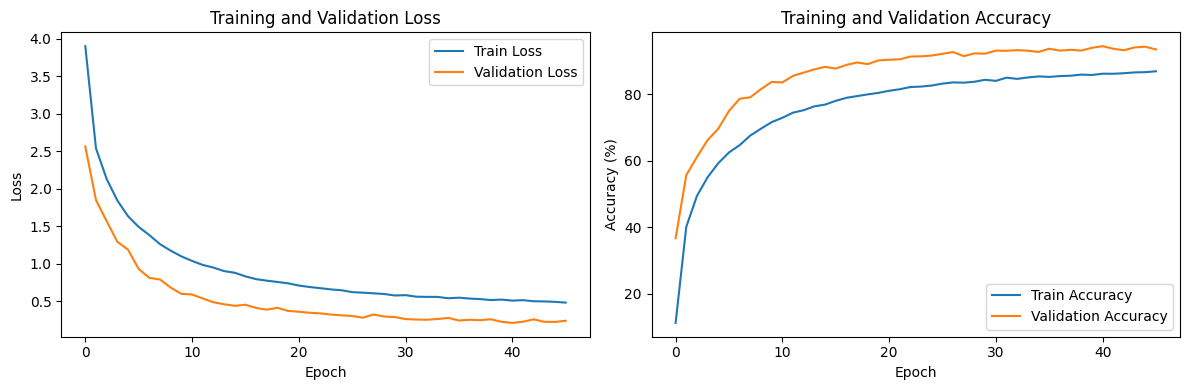

In [28]:
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion,
                     optimizer, NUM_EPOCHS, device)

model.load_state_dict(torch.load('best_model.pth'))
test_loss, classification_report = evaluate_model(
    model, test_loader, criterion, device, idx_to_word
)

print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print("\nClassification Report:")
print(classification_report)

plot_training_history(*history)

In [29]:
def test_image(model, image_path, transform, idx_to_word, device):

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        predicted_word = idx_to_word[predicted.item()]

        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence = probabilities[0][predicted].item()

    return predicted_word, confidence

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

image_path = "0_CHaNCe.png"
prediction, confidence = test_image(model, image_path, test_transform, idx_to_word, device)
print(f"Predicted word: {prediction}")
print(f"Confidence: {confidence:.2%}")

Predicted word: chance
Confidence: 99.99%
